### Model inspired by:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] Modelling and Control of Offshore Marine Pipeline during Pipelay. Gullik A. Jensen et al

### Motion equation used:
M(q)q ̈ + C(q,q ̇)q ̇ + H(q,q ̇)q ̇ + f(q) + g(q) = τ

### Implementation aspects:

- The model can be applied to normal dynamic pipelay condition for control purposes 

In [1]:
import numpy as np
import math
from scipy.integrate import odeint, ode, solve_ivp
from scipy.integrate import ode
from scipy.misc import derivative
from numpy.linalg import inv, pinv
import numdifftools as nd
import tqdm
import functools
from datetime import datetime
from scipy.optimize import fsolve
from scipy.linalg import lu_factor, lu_solve
import plotly.graph_objects as go

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

### Modelling data:

In [4]:
N = 9  # Number of simulation nodes

In [5]:
pipe_weight_per_unit_length = 59 #  (submerged) [kg/m]  

In [6]:
h = 40 # water depth, [m]

In [7]:
dq = np.zeros(N) #  these numbers are used for in itial checks only and redefined below

In [8]:
# Catenary

In [9]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]

In [10]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [11]:
Fx_0 = 604.76664*1000 # [N] (check catenary calculation script) 
Fx_ = 552.96894*1000 # [N] (check catenary calculation script) 

In [12]:
LTD = 255.21207 # [m] (check catenary calculation script) 

In [13]:
freeSpan = 2*(Fx_0/Ws)*(np.sinh(LTD*Ws/(2*Fx_0)))

In [14]:
freeSpan

255.84693682223448

In [15]:
delta_x = freeSpan/(N-1)

In [16]:
x0 = [i*delta_x for i in range(N+1)]
y0 = []
for i in range(len(x0)):
    y0.append(catenary(x0[i],Ws,Fx_))

In [17]:
q=[]
l=[]
rad_=[0]

for i in range(len(x0)-1):
    l.append(np.sqrt((x0[i+1]-x0[i])**2+(y0[i+1]-y0[i])**2))
    rad =np.arctan2((y0[i+1]-y0[i]),(x0[i+1]-x0[i]))
    q.append(rad-rad_[-1]) 
    rad_.append(rad)

In [18]:
l

[31.985347040406076,
 32.02119406965437,
 32.09292828813562,
 32.20063006096095,
 32.34442004869892,
 32.524459342990326,
 32.740949647588735,
 32.99413350501877,
 33.284294569090804]

In [19]:
pipe_joint_length = l[0]  # [m]
mn = 39_989_000 # mass of the vessel, [kg]
mn *= 9.81 # [N]

In [20]:
# L - the hull length
# Xg - x-center of gravity

L = 169 # [m]
Xg = 78 # [m]

In [21]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz = mn*Xg**2 + Ir
    return Iz

In [22]:
In = vessel_inertia_moment(mn, Xg, L)

In [23]:
In

3086970974465.625

In [24]:
mi = [x*pipe_weight_per_unit_length for x in l] # mass of pipe element (submerged), [kg]

In [25]:
# for hydrodynamic damping matrix
Cd=[0.87 for x in range(N)] # Drag coefficient
Cd[-1] = 1.6 

In [26]:
# Pipe
qw = 1025 # Water density [kg/m3]
d0 = 0.508 # Outer diameter of pipe, [m]
dI= (508-22.1*2)/1000 # Inner diameter of pipe, [m]

In [27]:
# for vector of spring forces in the pipe joints
E = 207e9 # modulus of elasticity of steel, [N/m^2]
EI = E*3.14/64*(d0**4-dI**4) # Bending stiffness [N*m^2]

In [28]:
K = EI

In [29]:
K

206414622.87219036

In [30]:
# Time integration params:
max_t = 10
DP_start = 3
X_REF = LTD+1

In [31]:
Awp = 6000 # the waterplane area of the vessel, [m^2]
fip = 1e12

In [32]:
# (control S-lay shape, can be adjusted for a certain stinger angle)
tau_qn = 6e5 # tension in pipe at water level, [N] - for vector of control inputs 
tau_q_wave = -9e5 # (derived by RAO),[N]

In [33]:
# (control S-lay shape, can be adjusted for a certain stinger angle)
# (control dynamics)
kp = 2.95e4
kd = 2.5e4

### System inertia matrix 

In [34]:
def alpha(q):
    sum_=0
    ans=[]
    for i in range(len(q)):
        sum_+=q[i]
        ans.append(sum_)
    return np.array(ans)

In [35]:
def Jv(q, i, l):
    alp=alpha(q)
    def Jv0(i, k, alp, l):
        
        if k<i:
            tmp1=np.dot(np.array(l[k:i]),np.sin(alp[k:i]))
            tmp1=-tmp1-0.5*l[i]*np.sin(alp[i])
            
            tmp2 =np.dot(np.array(l[k:i]),np.cos(alp[k:i]))
            tmp2=tmp2+0.5*l[i]*np.cos(alp[i])
                        
            return np.array([tmp1, tmp2]).T
        elif k==i:
            return np.array([-0.5*l[i]*np.sin(alp[i]),
                    0.5*l[i]*np.cos(alp[i])]).T
        else:
            return np.array([0, 0]).T                 
    
    ans=np.array([Jv0(i, k, alp, l) for k in range(len(q))])
    
    return ans.T

In [36]:
Jv(q, 2, l)

array([[-3.48166264, -2.9463453 , -1.3397934 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [79.95216776, 47.97130065, 15.99043355,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

In [37]:
def Jomega(i,q):

    def Jomega0(i,k):
        if k<=i:
            return 1
        return 0
    ans=np.array([Jomega0(i, k) for k in range(len(q))])
   
    return ans.reshape(len(q),1).T

In [38]:
def M(q, l, mn, In, mi):
  
    sum1 = mn * np.dot(Jv( q, len(q)-1, l).T, Jv(q, len(q)-1, l))
    
    sum2 = In * np.dot(Jomega(len(q)-1,q).T, Jomega(len(q)-1,q))

    sum3 = 0
    
    for i in range(len(q)-1):
        J_v = Jv(q, i, l)
        sum3+=mi[i]*np.dot(J_v.T, J_v)
      
    return (sum1 + sum2 + sum3)

In [39]:
M(q, l, mn, In, mi)

array([[3.26748931e+13, 2.92561966e+13, 2.58210815e+13, 2.23695222e+13,
        1.89014746e+13, 1.54168763e+13, 1.19156463e+13, 8.39768492e+12,
        4.86287408e+12],
       [2.92561966e+13, 2.62388535e+13, 2.32053154e+13, 2.01555565e+13,
        1.70895334e+13, 1.40071844e+13, 1.09084298e+13, 7.79317121e+12,
        4.66129220e+12],
       [2.58210815e+13, 2.32053154e+13, 2.05740290e+13, 1.79271966e+13,
        1.52647762e+13, 1.25867088e+13, 9.89291799e+12, 7.18330971e+12,
        4.45777234e+12],
       [2.23695222e+13, 2.01555565e+13, 1.79271966e+13, 1.56844182e+13,
        1.34271815e+13, 1.11554313e+13, 8.86909699e+12, 6.56809144e+12,
        4.25231125e+12],
       [1.89014746e+13, 1.70895334e+13, 1.52647762e+13, 1.34271815e+13,
        1.15767132e+13, 9.71332170e+12, 7.83694352e+12, 5.94750141e+12,
        4.04490349e+12],
       [1.54168763e+13, 1.40071844e+13, 1.25867088e+13, 1.11554313e+13,
        9.71332170e+12, 8.26033761e+12, 6.79642499e+12, 5.32151860e+12,
        3.8

### Coriolis-centripetal matrix

In [40]:
def C(q, dq, l, mn, In, mi): 
    ans = np.zeros((len(q),len(q)))              
    fun = lambda q: M(q, l, mn, In, mi)
    Dfun = nd.Gradient(fun) 
    
    diff = Dfun(q)

    
    def c(i,j,k):
        return 0.5 *(diff[k].item((i,j))+
                     diff[j].item((i,k))-
                     diff[i].item((j,k)))
    
    for i in range(len(q)):
        for j in range(len(q)):
            for k in range(len(q)):
                ans[i][j]+=c(i,j,k)*dq[k]
    return ans    

In [41]:
C(q, dq, l, mn, In, mi)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Hydrodynamic damping matrix

In [42]:
def R_I_Bi(i, alp):
    return np.array([[np.cos(alp[i]), -np.sin(alp[i])],
                    [np.sin(alp[i]), np.cos(alp[i])]])

In [43]:
alp=alpha(q)
dalp=alpha(dq)

In [44]:
R_I_Bi(2, alp)

array([[ 0.99650823, -0.08349462],
       [ 0.08349462,  0.99650823]])

In [45]:
I_=np.array([[0,0],
             [0,1]])

In [46]:
def Pi(i,alp):
    return np.dot(np.dot(R_I_Bi(i, alp),I_),R_I_Bi(i, alp).T)

In [47]:
def mod_Vn(q, alp, dq):
    ans=[]
    for j in range(len(q)):
        ans.append(np.dot(np.dot(Pi(j,alp),Jv( q,j, l)), dq))
    return np.linalg.norm(np.array(ans))

In [48]:
mod_Vn(q,alp,dq)

0.0

In [49]:
def mod_Vni(i,q,alp,dq):
    return np.linalg.norm(np.dot(np.dot(Pi(i,alp),Jv( q,i, l)), dq))

In [50]:
mod_Vni(len(q)-1,q,alp,dq)

0.0

In [51]:
def gamma(i):
    return 0.5*Cd[i]*qw*d0*l[i]

In [52]:
def H(alp,q,dq,l):
    ans=np.zeros((len(q), len(q)))
    alp=alpha(q)
    for j in range(len(q)):
        ans+=gamma(j)*mod_Vni(j,q,alp,dq)*np.dot(np.dot(Jv(q,j,l).T,Pi(j,alp)),Jv( q,j, l))
    return ans    

In [53]:
alp

array([0.01673711, 0.05019259, 0.08359194, 0.11689808, 0.15007446,
       0.18308523, 0.21589547, 0.24847129, 0.28078009])

In [54]:
H(alp,q,dq,l)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Vector of spring forces in the pipe joints

In [55]:
def f(q,k):
    ans=np.array([k*q[i] for i in range(len(q))])
    return ans.reshape(len(q),1)

### Vector of gravitational/buoyancy forces

In [56]:
def x_(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.cos(alp[:i]))

    tmp1+=0.5*l[i]*np.cos(alp[i])
    return tmp1

In [57]:
x_(alp,2,l)

79.95216775694828

In [58]:
def y_(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.sin(alp[:i]))
    tmp1+=0.5*l[i]*np.sin(alp[i])
    return tmp1

In [59]:
y_(alp,2,l)

3.4816626373774415

In [60]:
G=np.array([0,-9.81]).T

def ggi(i,G):
    return mi[i]*G
   
    
def gbi(G,l,i):
    return -3.14*l[i]*(d0**2/4)*qw*G 


def gt(alp, dalp, fip, i): 
    return -fip*(alp[i] - dalp[i])


In [61]:
def g(q, alp, dalp):
    sum_=0
    for i in range(len(q)-1):
        sum_+=np.dot(Jv( q,i, l).T,ggi(i,G)+gbi(G,l,i))
    tmp = -qw*Awp*(y_(alp,len(alp)-1,l)-h)*G 
    sum_ += np.dot(Jv(q,len(q)-1, l).T, tmp) 
    ans = sum_.reshape(len(q),1) +np.dot(Jomega(len(q)-1,q).T, gt(alp,dalp,fip, len(q)-1))
    return  ans 

In [62]:
g(q,alp, dalp)

array([[-2.95919025e+11],
       [-2.94143586e+11],
       [-2.92366655e+11],
       [-2.90588229e+11],
       [-2.88808304e+11],
       [-2.87026874e+11],
       [-2.85243931e+11],
       [-2.83459467e+11],
       [-2.81673470e+11]])

### Vector of control inputs

In [63]:
# Assume that the stinger is shorter than the link length li for any link i
def tau_q(q,tau_qn): 
    ans= np.array([0 for i in range(len(q))]).reshape(len(q),1)
    ans[-1] = tau_qn
    return ans

In [64]:
def Fx(q,alp,dq,kp, kd, x_ref = 0):
    return -kp*(x_(alp,len(q)-1,l)-x_ref) - kd*mod_Vn(q,alp,dq)

In [65]:
Fx(q,alp,dq,kp, kd, x_ref = X_REF)

-460946.36102191097

In [66]:
# F1=np.array([Fx_,0]).reshape(2,1) # actuates the vessel in the surge direction in frame Bn
F1= np.array([-Fx(q, alp, dq, kp, kd, x_ref = X_REF),0]).reshape(2,1) 
def tau_t(q, F):
    tmp= np.dot(Jv(q,len(q)-1, l).T, F)
    return tmp

In [67]:
tau_t(q, F1)

array([[-18010996.02031531],
       [-17764243.44256986],
       [-17023709.19141276],
       [-15788563.4032077 ],
       [-14057421.93863458],
       [-11828344.83158335],
       [ -9098834.11517317],
       [ -5865831.02246037],
       [ -2125712.55869748]])

In [68]:
y_(alp,0,l),y_(alp,len(q)-1,l)

(0.267658667700945, 39.073952076300614)

In [69]:
def tau_wave(q, alp, tau_q_wave): 
    A0 = tau_q_wave         
    k = 0.5          
    ans=[]
    for i in range(len(q)):
        ans.append([tau_q_wave * np.exp(-k * (y_(alp,len(q)-1,l)-y_(alp,i,l)))])   
    return np.array(ans)

In [70]:
def tau(q, alp, tau_qn, F, tau_q_wave):
    return tau_t(q, F) + tau_wave(q, alp, tau_q_wave) +tau_q(q,tau_qn)

In [71]:
tau_wave(q,alp, tau_q_wave)

array([[-3.36948063e-03],
       [-5.75590293e-03],
       [-1.68064140e-02],
       [-8.39787204e-02],
       [-7.19414226e-01],
       [-1.05913104e+01],
       [-2.68775785e+02],
       [-1.17997880e+04],
       [-9.00000000e+05]])

In [72]:
tau(q, alp, tau_qn, F1, tau_q_wave)

array([[-18010996.02368479],
       [-17764243.44832576],
       [-17023709.20821917],
       [-15788563.48718642],
       [-14057422.65804881],
       [-11828355.42289376],
       [ -9099102.89095832],
       [ -5877630.8104837 ],
       [ -2425712.55869748]])

In [73]:
q

[0.0167371117999116,
 0.03345547802345767,
 0.03339934612874998,
 0.03330614099149325,
 0.03317637968314473,
 0.033010776313018686,
 0.03281023253181034,
 0.03257582572890019,
 0.0323087952063163]

### Static solution

In [74]:
alp_=alpha(q)

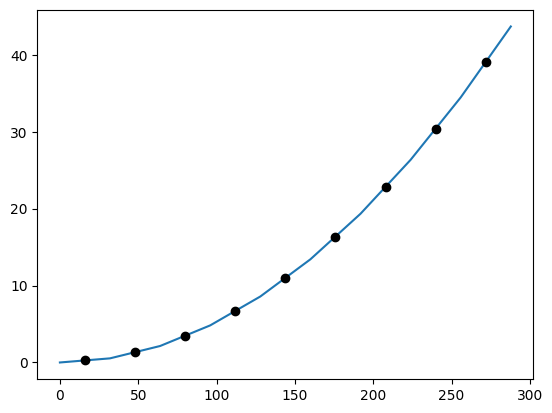

In [75]:
plt.plot(x0, y0)
for i in range(len(q)):
    plt.plot(x_(alp_,i,l),y_(alp_,i,l), 'o', color='black')
plt.show()

In [76]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    
for i in range(len(q)):    
    q0.append(0)

In [77]:
dq

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
q

[0.0167371117999116,
 0.03345547802345767,
 0.03339934612874998,
 0.03330614099149325,
 0.03317637968314473,
 0.033010776313018686,
 0.03281023253181034,
 0.03257582572890019,
 0.0323087952063163]

In [79]:
def static_func(q):
    alp=alpha(q)
    dalp=alpha(dq)
    F_=np.array([-Fx(q,alp,dq,kp, 0, x_ref = X_REF),0]).reshape(2,1)
    ans=  f(q, K)-g(q,alp,dalp) - tau(q,alp, tau_qn, F_, 0)
    return ans.reshape((len(q),))

In [80]:
root = fsolve(static_func, np.array(q).astype(np.float64))

In [81]:
root

array([ 0.11708669,  0.06690772,  0.02918178,  0.00085439, -0.02035314,
       -0.03603535, -0.04725182, -0.05466147, -0.05571626])

In [82]:
q = list(root) 

In [83]:
q

[0.11708668552971917,
 0.06690771873658194,
 0.02918178216339034,
 0.000854388552818954,
 -0.020353139009285225,
 -0.03603534551158243,
 -0.04725181886458731,
 -0.05466146854280863,
 -0.055716255513604505]

In [84]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    
for i in range(len(q)):  
    q0.append(0)

In [85]:
alp_=alpha(root) 

In [86]:
alp_

array([1.17086686e-01, 1.83994404e-01, 2.13176186e-01, 2.14030575e-01,
       1.93677436e-01, 1.57642090e-01, 1.10390272e-01, 5.57288031e-02,
       1.25475406e-05])

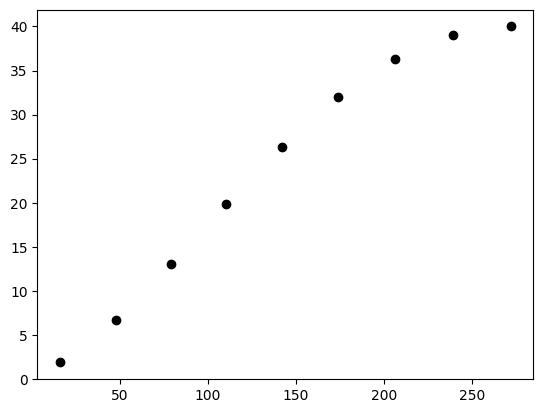

In [87]:
for i in range(len(q)):
    plt.plot(x_(alp_,i,l),y_(alp_,i,l), 'o', color='black')
plt.show()

In [88]:
q0

[0.11708668552971917,
 0.06690771873658194,
 0.02918178216339034,
 0.000854388552818954,
 -0.020353139009285225,
 -0.03603534551158243,
 -0.04725181886458731,
 -0.05466146854280863,
 -0.055716255513604505,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [89]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, [q])))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, [q])))

add6=functools.partial(g,alp=alp_, dalp=dalp)
add6__g =np.array(list(map(add6, [q])))

print(datetime.now() - startTime)

0:00:00.002342


In [90]:
tmp__1 = pinv(add1__Jv.transpose(0, 2, 1))
tmp__2 = add5__f + add6__g

In [91]:
tmp__ = np.matmul(tmp__1, tmp__2)

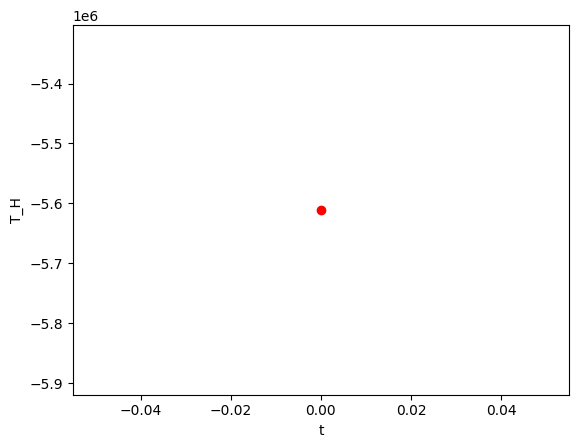

In [92]:
plt.plot(0,tmp__[:,0],'o', color='red')
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

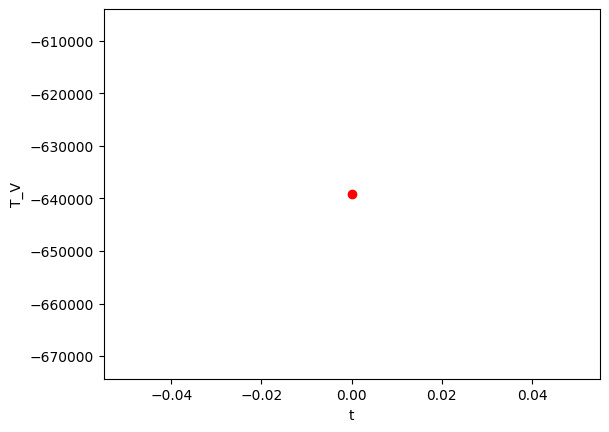

In [93]:
plt.plot(0,tmp__[:,1],'o', color='red')
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [94]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([-5610924.7831716]), array([-639151.06433602]))

### Dynamic solution 

In [95]:
def dynamic_func( t,Q, q):

    q, dq = Q[0:N], Q[N:]
    QI = q.reshape(len(q),1)
    dQ = dq.reshape(len(q),1)
    
    QI = QI.flatten().tolist()
 
 
    alp = alpha(QI)
    dalp = alpha(dQ.flatten().tolist())

    if t > DP_start:
        F = np.array([-Fx(QI, alp, dQ, kp, kd, x_ref = X_REF),0]).reshape(2,1) 
    else:
        F = np.array([Fx_0, 0]).reshape(2,1)
    
    ddq = np.linalg.solve(M(QI, l, mn, In, mi), 
                        - np.dot(H(alp,QI,dQ,l), dQ).reshape(len(QI),1)
                        - np.dot(C(QI,dQ, l, mn, In, mi), dQ) 
                        - f(QI, K) 
                        - g(QI,alp, dalp) 
                        + tau(QI,alp, tau_qn, F, tau_q_wave)).flatten()
      
    ans=np.concatenate([dq, ddq], axis=0)
        
    return ans

In [96]:
q

[0.11708668552971917,
 0.06690771873658194,
 0.02918178216339034,
 0.000854388552818954,
 -0.020353139009285225,
 -0.03603534551158243,
 -0.04725181886458731,
 -0.05466146854280863,
 -0.055716255513604505]

In [97]:
startTime1 = datetime.now()
us=solve_ivp(dynamic_func, (0,max_t),q0, args=(q,))
print(datetime.now() - startTime1)

18:41:19.377652


In [98]:
us_=us.y.T
t_=us.t

In [99]:
us_.shape

(119565, 18)

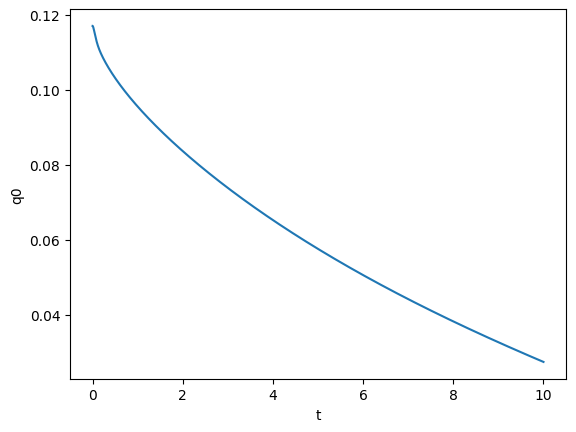

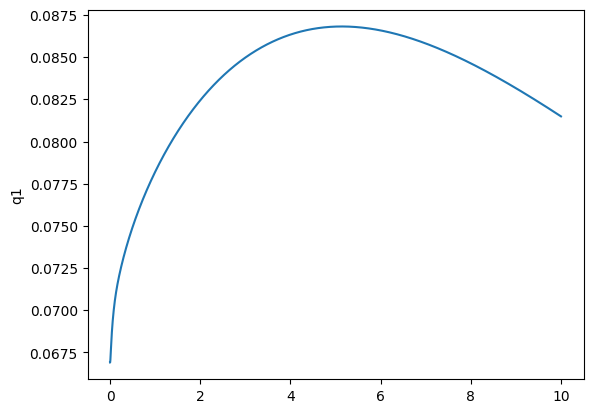

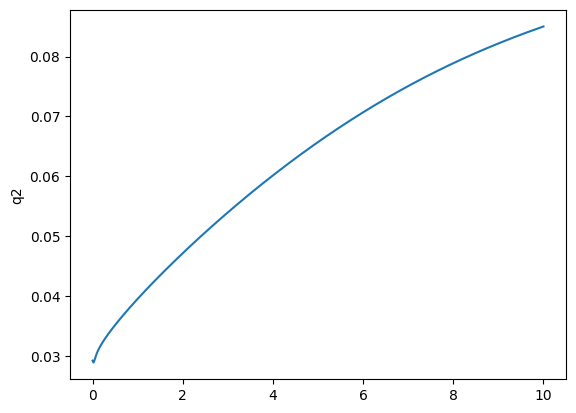

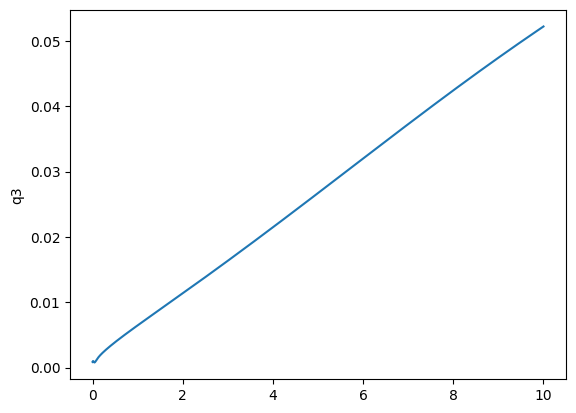

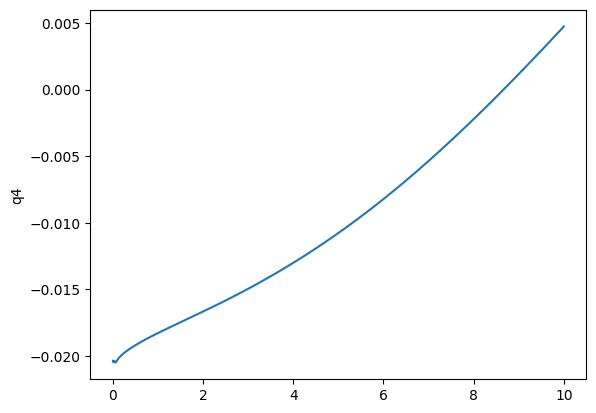

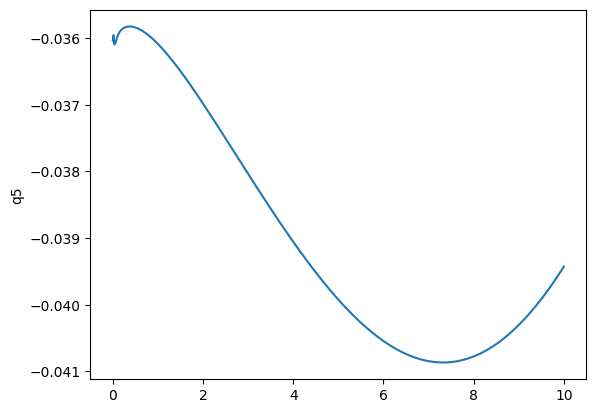

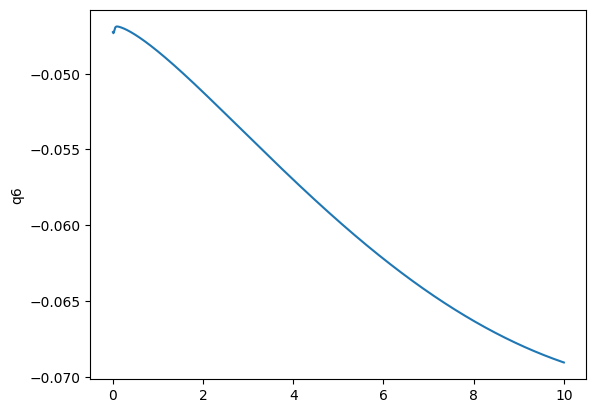

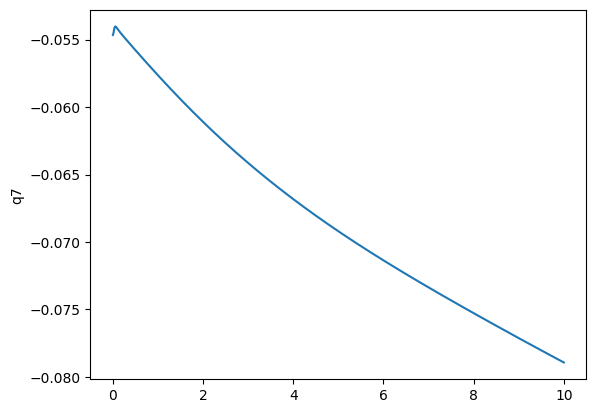

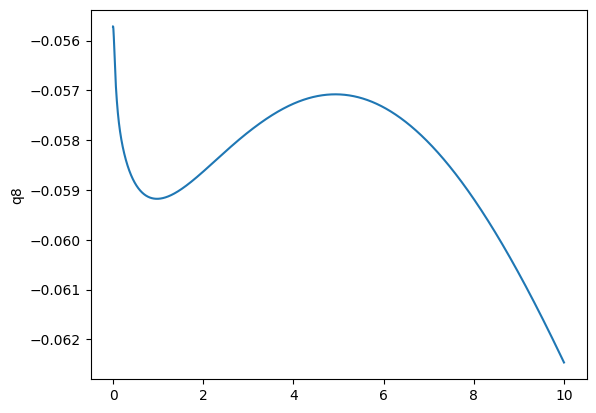

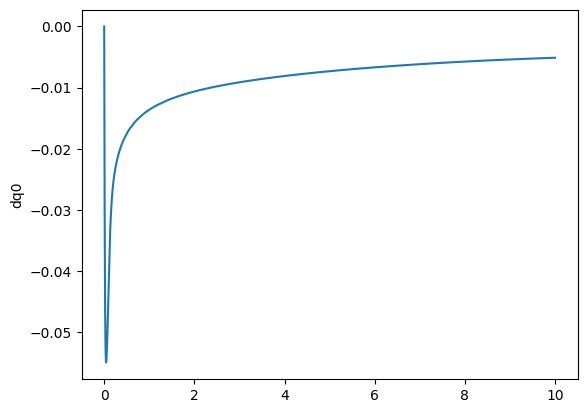

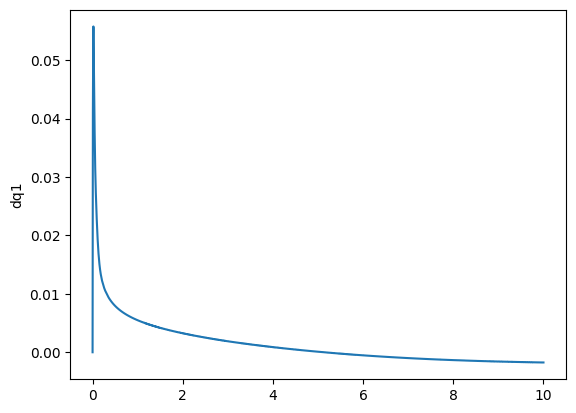

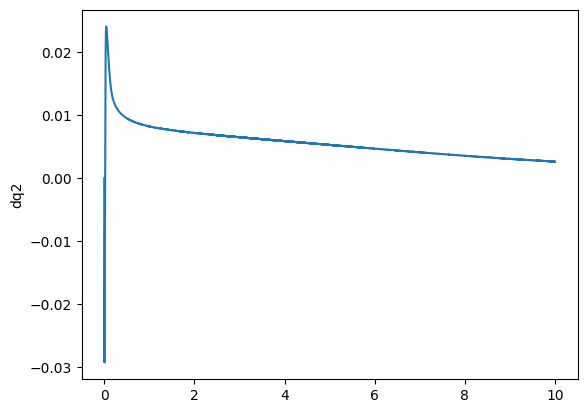

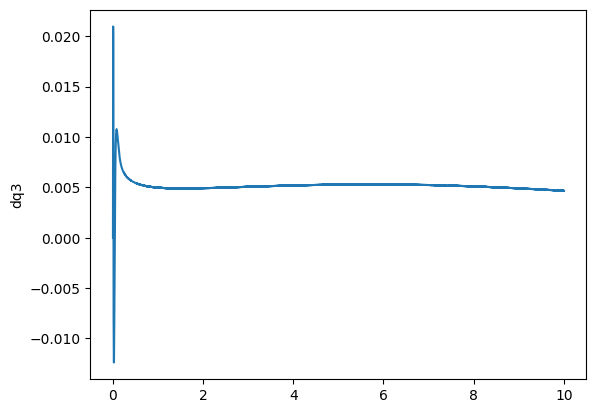

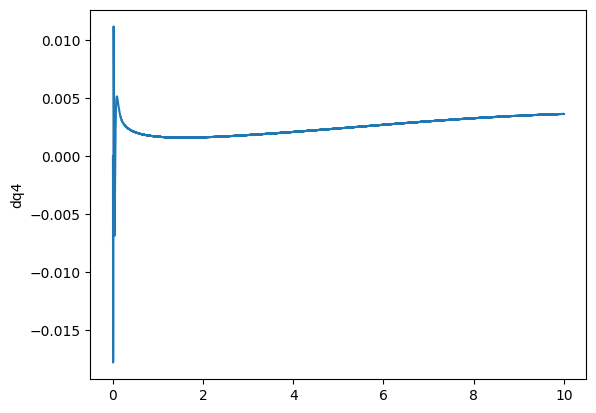

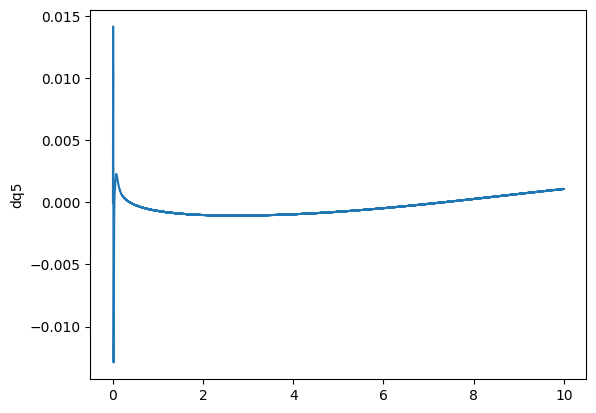

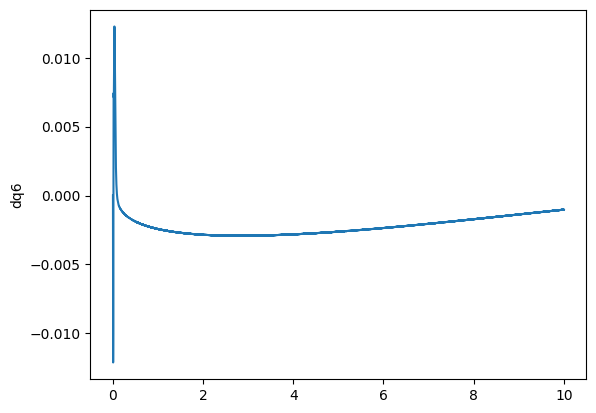

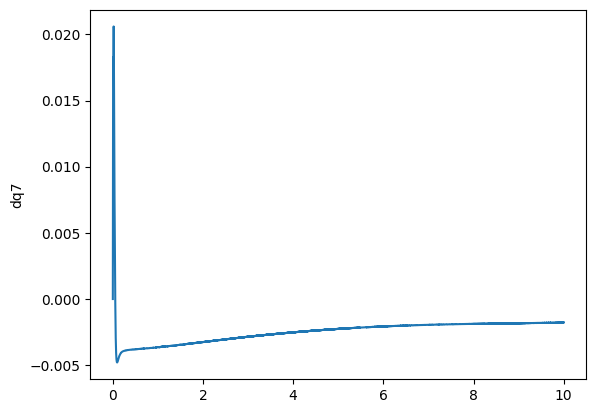

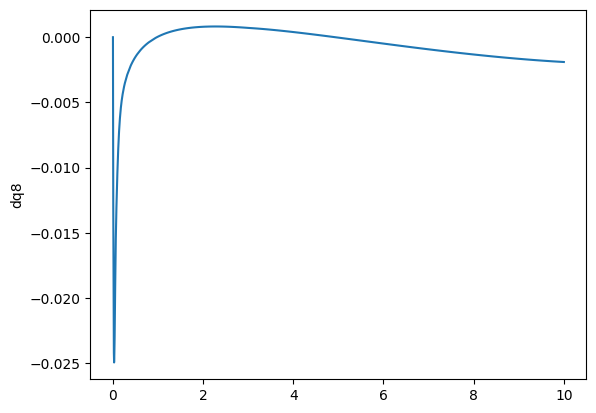

In [100]:
plt.xlabel('t')
for i in range(len(q0)):
    if i<len(q0)//2:
        plt.plot(t_,us_[:,i] ,'-')
        plt.ylabel('q{}'.format(i))
    else:
        plt.plot(t_, us_[:,i],'-')
        plt.ylabel('{}q{}'.format('d',i-len(q)))
    plt.show()        

In [101]:
horizon_start = 0

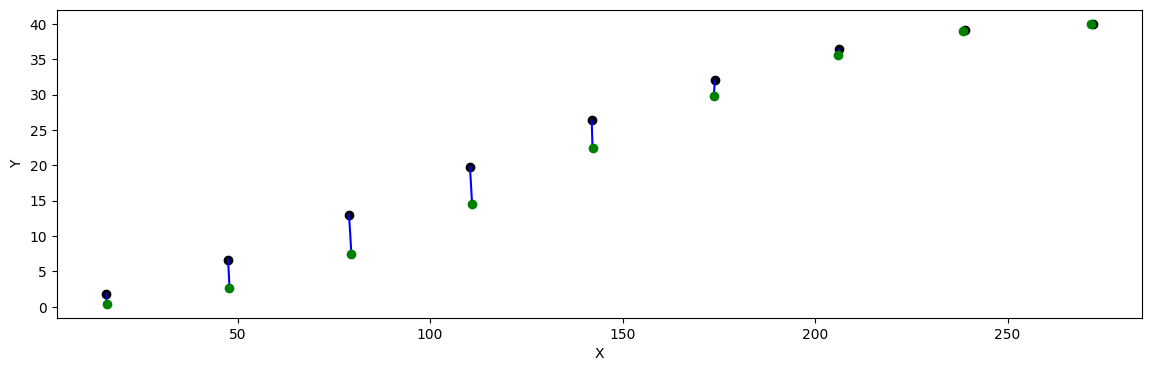

In [102]:
plt.figure(figsize=(14,4))
plt.xlabel('X')
plt.ylabel('Y')

for j in range(len(q)):
    X = [x_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),j,l) for i in range(horizon_start, len(us_))]
    Y = [y_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),j,l) for i in range(horizon_start, len(us_))]
    X_ = [x_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),j,l) for i in range(1)]
    Y_ = [y_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),j,l) for i in range(1)]
    plt.plot(X_,Y_, 'o', color='black')
    
    # dynamic
    plt.plot(X,Y,'b')   
    
    plt.plot(x_(alpha(us_[-1,[k for k in range(0,len(q0)//2)]]),j,l),
             y_(alpha(us_[-1,[k for k in range(0,len(q0)//2)]]),j,l), 'o', color='green')
plt.show()

### Pipe-tip tension

In [103]:
coordinates=us_[:,[k for k in range(0,len(q0)//2)]]
velocities=us_[:,[k for k in range(len(q0)//2,len(q0))]]

In [104]:
alp_=[]
for i in range(len(us_)):
    alp_.append(alpha(coordinates[i]))
alp_=np.matrix(alp_) 


dalp_=[]
for i in range(len(us_)):
    dalp_.append(alpha(velocities[i]))
dalp_=np.matrix(dalp_)   

In [105]:
velocities.shape

(119565, 9)

In [106]:
velocities_0 = velocities[:-1]
velocities_1 = velocities[1:]

In [107]:
coordinates.shape, velocities.shape

((119565, 9), (119565, 9))

In [108]:
startTime1 = datetime.now()

add4=functools.partial(C, l=l, mn=mn, In=In, mi=mi)
add4__C =np.array(list(map(add4, coordinates, velocities)))

print(datetime.now() - startTime1)

2:38:37.845975


In [109]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, coordinates)))

add2=functools.partial(M, l=l, mn=mn, In=In, mi=mi)
add2__M =np.array(list(map(add2, coordinates)))

add3=functools.partial(H,  l=l)
add3__H =np.array(list(map(add3, alp_.tolist(), coordinates, velocities)))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, coordinates)))

add6=functools.partial(g)
add6__g =np.array(list(map(add6, coordinates, alp_.tolist(),dalp_.tolist())))

print(datetime.now() - startTime)

0:02:43.222006


In [110]:
velocities_1.shape

(119564, 9)

In [111]:
add5__f.shape

(119565, 9, 1)

In [112]:
add6__g.shape

(119565, 9, 1)

In [113]:
add3__H.shape

(119565, 9, 9)

In [114]:
dt=max_t/us_.shape[0]

In [115]:
tmp__1 = pinv(add1__Jv[:-1].transpose(0, 2, 1))
tmp__2 = np.matmul(add2__M[:-1], (velocities_1.reshape(len(velocities_1),len(q),1)
                                  - velocities_0.reshape(len(velocities_0),len(q),1))/dt)\
            + np.matmul(add3__H[:-1], velocities[:-1].reshape(len(velocities_0),len(q),1)) \
            + np.matmul(add4__C[:-1], velocities[:-1].reshape(len(velocities_0),len(q),1)) \
            + add5__f[:-1] \
            + add6__g[:-1]

In [116]:
add1__Jv[:-1].shape

(119564, 2, 9)

In [117]:
tmp__2.shape

(119564, 9, 1)

In [118]:
tmp__=np.matmul(tmp__1, tmp__2)

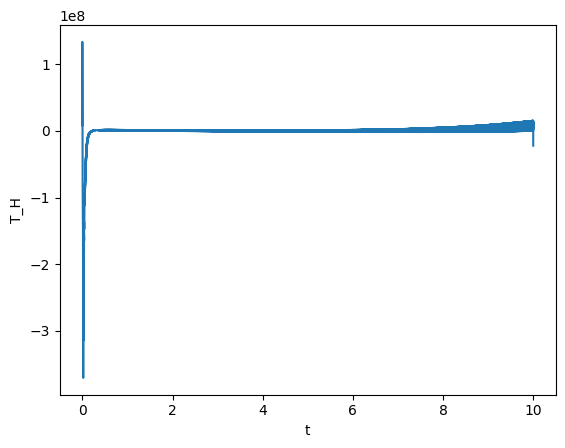

In [119]:
plt.plot(t_[:len(tmp__)],tmp__[:,0],'-')
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

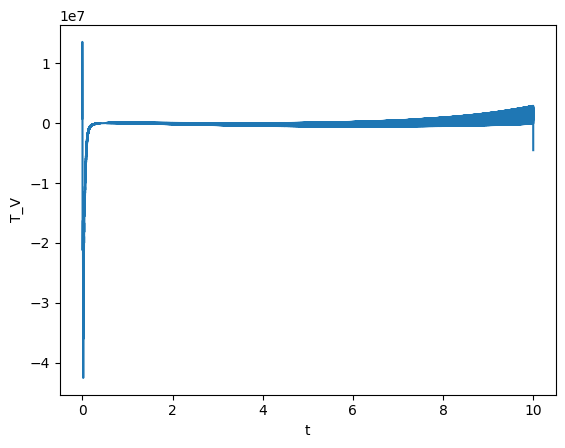

In [120]:
plt.plot(t_[:len(tmp__)],tmp__[:,1],'-')
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [121]:
# Axial strain

In [122]:
Af = 3.14/4*(d0**2-dI**2)

In [123]:
np.max(tmp__[:,0])/(E*Af)

0.01909683198687493

In [124]:
np.min(tmp__[:,0])/(E*Af)

-0.053085236543904284

In [125]:
# Bending strain

In [126]:
Mmax=np.max(tmp__[:,1])*l[-1]

In [127]:
W = 3.14*(d0**4-dI**4)/(32*d0)

In [128]:
I = 3.14*(d0**4-dI**4)/64

In [129]:
c=d0/2

In [130]:
(Mmax/W)/E

0.5558251011076264

In [131]:
Mmax*c/(I*E)

0.5558251011076264

In [132]:
Mmin=np.min(tmp__[:,1])*l[-1]

In [133]:
(Mmin/W)/E

-1.7424157261503004

In [134]:
Mmin*c/(I*E)

-1.7424157261503

In [135]:
# Hs

In [136]:
X111 = [x_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),N-4,l) for i in range(0, len(us_))]
Y111 = [y_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),N-4,l) for i in range(0, len(us_))]
X111_ = [x_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),N-4,l) for i in range(1)]
Y111_ = [y_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),N-4,l) for i in range(1)]

In [137]:
(np.max(Y111)-np.min(Y111))

2.1717423584439928

In [138]:
X1111 = [x_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),N-3,l) for i in range(0, len(us_))]
Y1111 = [y_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),N-3,l) for i in range(0, len(us_))]
X1111_ = [x_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),N-3,l) for i in range(1)]
Y1111_ = [y_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),N-3,l) for i in range(1)]

In [139]:
(np.max(Y1111)-np.min(Y1111))

0.7915020055643964

In [140]:
X010=[]
Y010=[]

In [141]:
for j in range(len(q)):
    X = [x_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),j,l) for i in range(horizon_start, len(us_))]
    Y = [y_(alpha(us_[i,[k for k in range(0,len(q0)//2)]]),j,l) for i in range(horizon_start, len(us_))]
    X010.append(X)
    Y010.append(Y)

In [142]:
X010=np.array(X010).T
Y010=np.array(Y010).T

In [143]:
X010.shape 

(119565, 9)

In [144]:
# simulation = np.stack([X010, Y010], axis=2) 

# FPS = 6                      
# frame_duration = 1000 / FPS

# frames = []
# for t in range(simulation.shape[0]):
#     x = simulation[t,:,0]
#     y = simulation[t,:,1]

#     frames.append(go.Frame(
#         data=[
#             go.Scatter(
#                 x=x, y=y,
#                 mode="lines+markers",
#                 marker=dict(size=5, color=list(range(12)), colorscale="Viridis"),
#                 line=dict(width=4)
#             )
#         ],
#         name=f"t={t}"
#     ))

# # First frame
# x0, y0  = simulation[0,:,0], simulation[0,:,1]

# fig = go.Figure(
#     data=[go.Scatter(x=x0, y=y0, mode="lines+markers")],
#     frames=frames
# )

# # Animation controls
# fig.update_layout(
#     title="Pipeline Simulation ",
#     scene=dict(
#         xaxis_title="X",
#         yaxis_title="Y",
#         xaxis=dict(range=[0, 300]),
#         yaxis=dict(range=[0, 40]),
#         aspectmode="data",
       
#     ),
#     updatemenus=[{
#         "type": "buttons",
#         "buttons": [
#             {
#                 "label": "Play",
#                 "method": "animate",
#                 "args": [None, {"frame": {"duration": frame_duration, "redraw": True}}]
#             },
#             {
#                 "label": "Pause",
#                 "method": "animate",
#                 "args": [[None], {"frame": {"duration": 0}}]
#             }
#         ]
#     }]
# )

# fig.show()